In [1]:
# reload environment
%load_ext autoreload
%autoreload 2

# how many sequences to use? 
# Anthropic trained on 40,960,000 tokens
# And they most likely used 1024 as context length
# So 40_960_000 / 1024 = 40_000 sequences
# I have 512 context length but I can still use 40_000 sequences
# with batch size 128, this amounts to 40_000 / 128 = 312.5 batches

In [2]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

from itertools import combinations
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px
import torch
import numpy as np
from univ_utils import load_model_and_sae, get_running_activation_stats, load_data
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Universality across models for final checkpoints

In [4]:
# new model-sae pairs, all 24k latents
model_sae_pairs = [
    ("8-768", "443ngubm"),
    ("8-512", "fyqbawtf"),
    ("8-256", "7g6hq05j"),
    ("8-128", "ngd29532"),
]

In [5]:
# load all stats
all_stats = {}
all_max_acts = {}
all_densities = {}
for (model1_name, sae1_name), (model2_name, sae2_name) in combinations(model_sae_pairs, 2):
    stats = torch.load(f"stats_data/stats_{model1_name}_{model2_name}_{sae1_name}_{sae2_name}.pt").to_cpu()
    all_stats[(model1_name, sae1_name), (model2_name, sae2_name)] = stats

    # TODO: assuming here that stats.max_x is the same for all features regardless of which pair they come from
    if (model1_name, sae1_name) not in all_max_acts:
        all_max_acts[(model1_name, sae1_name)] = np.copy(stats.max_x)
        all_densities[(model1_name, sae1_name)] = stats.density_x
    elif (model2_name, sae2_name) not in all_max_acts:
        all_max_acts[(model2_name, sae2_name)] = np.copy(stats.max_y)
        all_densities[(model2_name, sae2_name)] = stats.density_y


/tmp/ipykernel_165859/1078316742.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stats = torch.load(f"stats_data/stats_{model1_name}_{model2_name}_{sae1_name}_{sae2_name

In [7]:
# load all masks
loaded_masks = {}
for model1_name, sae1_name in model_sae_pairs:
    uninterpretable_cluster_indices = torch.load(
        f"sae_checkpoints/{model1_name}-final/{sae1_name}/final_1024000000/uninterpretable_cluster_indices.pt")
    print(f"Model {model1_name} has {uninterpretable_cluster_indices.sum()} uninterpretable features")
    loaded_masks[(model1_name, sae1_name)] = uninterpretable_cluster_indices

Model 8-768 has 261 uninterpretable features
Model 8-512 has 253 uninterpretable features
Model 8-256 has 1040 uninterpretable features
Model 8-128 has 4483 uninterpretable features


/tmp/ipykernel_165859/1870166567.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uninterpretable_cluster_indices = torch.load(


### Plot feature importance vs activation similarity

In [7]:
all_scatter_data = []
all_corr_coefs = []
all_subplot_titles = []
masked_scatter_data = []
masked_corr_coefs = []
masked_subplot_titles = []
masks = []
num_layers = lambda model_name: int((model_name.split("-"))[1])

for model1_name, sae1_name in model_sae_pairs:
    for model2_name, sae2_name in model_sae_pairs:
        if model1_name == model2_name:
            all_subplot_titles.append("____")
            masked_subplot_titles.append("____")
            continue

        if ((model1_name, sae1_name), (model2_name, sae2_name)) in all_stats:
            stats = all_stats[(model1_name, sae1_name), (model2_name, sae2_name)]
            x = stats.max_x 
            y = stats.corr_matrix.amax(dim=-1)
        else:
            stats = all_stats[(model2_name, sae2_name), (model1_name, sae1_name)]
            x = stats.max_y 
            y = stats.corr_matrix.amax(dim=0)

        x = x / x.max() # relative feature importance

        all_scatter_data.append((x, y))

        # corr coef
        corr_coef = torch.corrcoef(torch.stack((x, y), dim=0))[0, 1].item()
        all_corr_coefs.append(corr_coef)

        # masked scatter plot data
        mask = loaded_masks[(model1_name, sae1_name)]
        masks.append(np.copy(mask))
        x = x[~mask]
        y = y[~mask]
        masked_scatter_data.append((x, y))
        masked_corr_coef = torch.corrcoef(torch.stack((x, y), dim=0))[0, 1].item()
        masked_corr_coefs.append(masked_corr_coef)


        # subplot title
        nl1, nl2 = num_layers(model1_name), num_layers(model2_name)
        all_subplot_titles.append(f"Corr={corr_coef:.4f}")
        masked_subplot_titles.append(f"Corr={masked_corr_coef:.4f}")

In [8]:
grid_length = len(model_sae_pairs)
grid_titles = [f"n_layers={model_name.split('-')[1]}" for model_name, _ in model_sae_pairs]

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

def exp_func(x, a, b, c):
    return a * (1 - np.exp(-b * (x - c)))

def fit_exp_curve(x, y, density):
    # List of initial parameter guesses to try
    initial_guesses = [
        [1, 5, 0.5],
        [1, 1, 0.4],
        [0.8, 10, 0.3],
        [1.2, 3, 0.45]
    ]
    
    # Set bounds for parameters [a, b, c]
    # a: asymptote (0.5 to 2)
    # b: rate (0.1 to 20)
    # c: offset (0.1 to max(x))
    bounds = ([0.5, 0.1, 0.1], [2.0, 20.0, max(x)])
    
    for p0 in initial_guesses:
        try:
            popt, _ = curve_fit(exp_func, x, y, p0=p0, 
                              sigma=1/density, 
                              bounds=bounds,
                              maxfev=2000)  # Increase max iterations
            return popt
        except:
            continue
    
    return None

def plot_grid_matplotlib_with_fit(scatter_data, corr_coefs, grid_length=grid_length, grid_titles=grid_titles):
    # Create the subplot grid
    fig, axes = plt.subplots(grid_length, grid_length, figsize=(15, 15))
    plt.suptitle("Feature Importance (x-axis) vs Universality (y-axis)", y=0.92)

    i = 0
    for row in range(grid_length):
        for col in range(grid_length):
            ax = axes[row, col]
            if row == col:
                # Hide diagonal subplots
                ax.axis("off")
                continue
            
            # Get data and convert to numpy if needed
            x, y = scatter_data[i]
            if hasattr(x, 'cpu'):
                x = x.cpu().numpy()
                y = y.cpu().numpy()

            # Compute density
            xy = np.vstack([x, y])
            kernel = gaussian_kde(xy)
            density = kernel(xy)

            # Sort points by density
            idx = density.argsort()
            x_sorted, y_sorted, density_sorted = x[idx], y[idx], density[idx]

            # Plot scatter with density coloring
            scatter = ax.scatter(x_sorted, y_sorted, c=density_sorted, 
                               s=1, alpha=0.5, cmap='viridis')

            # Try fitting with different initial parameters
            popt = fit_exp_curve(x, y, density)

            # Plot fitted curve if successful
            if popt is not None:
                x_fit = np.linspace(x.min(), x.max(), 1000)
                y_fit = exp_func(x_fit, *popt)
                ax.plot(x_fit, y_fit, 'r-', linewidth=2)
                fit_text = f"\ny={popt[0]:.2f}(1-e^(-{popt[1]:.2f}(x-{popt[2]:.2f})))"
            else:
                print(f"Fitting failed for subplot [{row}, {col}]")
                fit_text = "\nFit failed"

            # Add contours
            xgrid = np.linspace(x.min(), x.max(), 50)
            ygrid = np.linspace(y.min(), y.max(), 50)
            Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
            positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
            Z = kernel(positions).reshape(Xgrid.shape)
            ax.contour(Xgrid, Ygrid, Z, levels=8, colors='k', alpha=0.3)

            # Set titles and labels
            corr_coef = corr_coefs[i]
            ax.set_title(f"r={corr_coef:.4f}{fit_text}", fontsize=8)
            
            if col == 0:
                ax.set_ylabel(grid_titles[row], fontsize=10)
            if row == grid_length - 1:
                ax.set_xlabel(grid_titles[col], fontsize=10)
            
            # Set axis limits
            ax.set_ylim(0, 1.0)
            ax.grid(True, alpha=0.3)
            
            i += 1

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(scatter, cax=cbar_ax, label='Density')

    # Adjust spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.4, right=0.9)

    #os.makedirs("figs", exist_ok=True)
    #plt.savefig("figs/imp_vs_univ.pdf", format="pdf", bbox_inches="tight")

    # Display the plot
    plt.show()

    return fig, axes

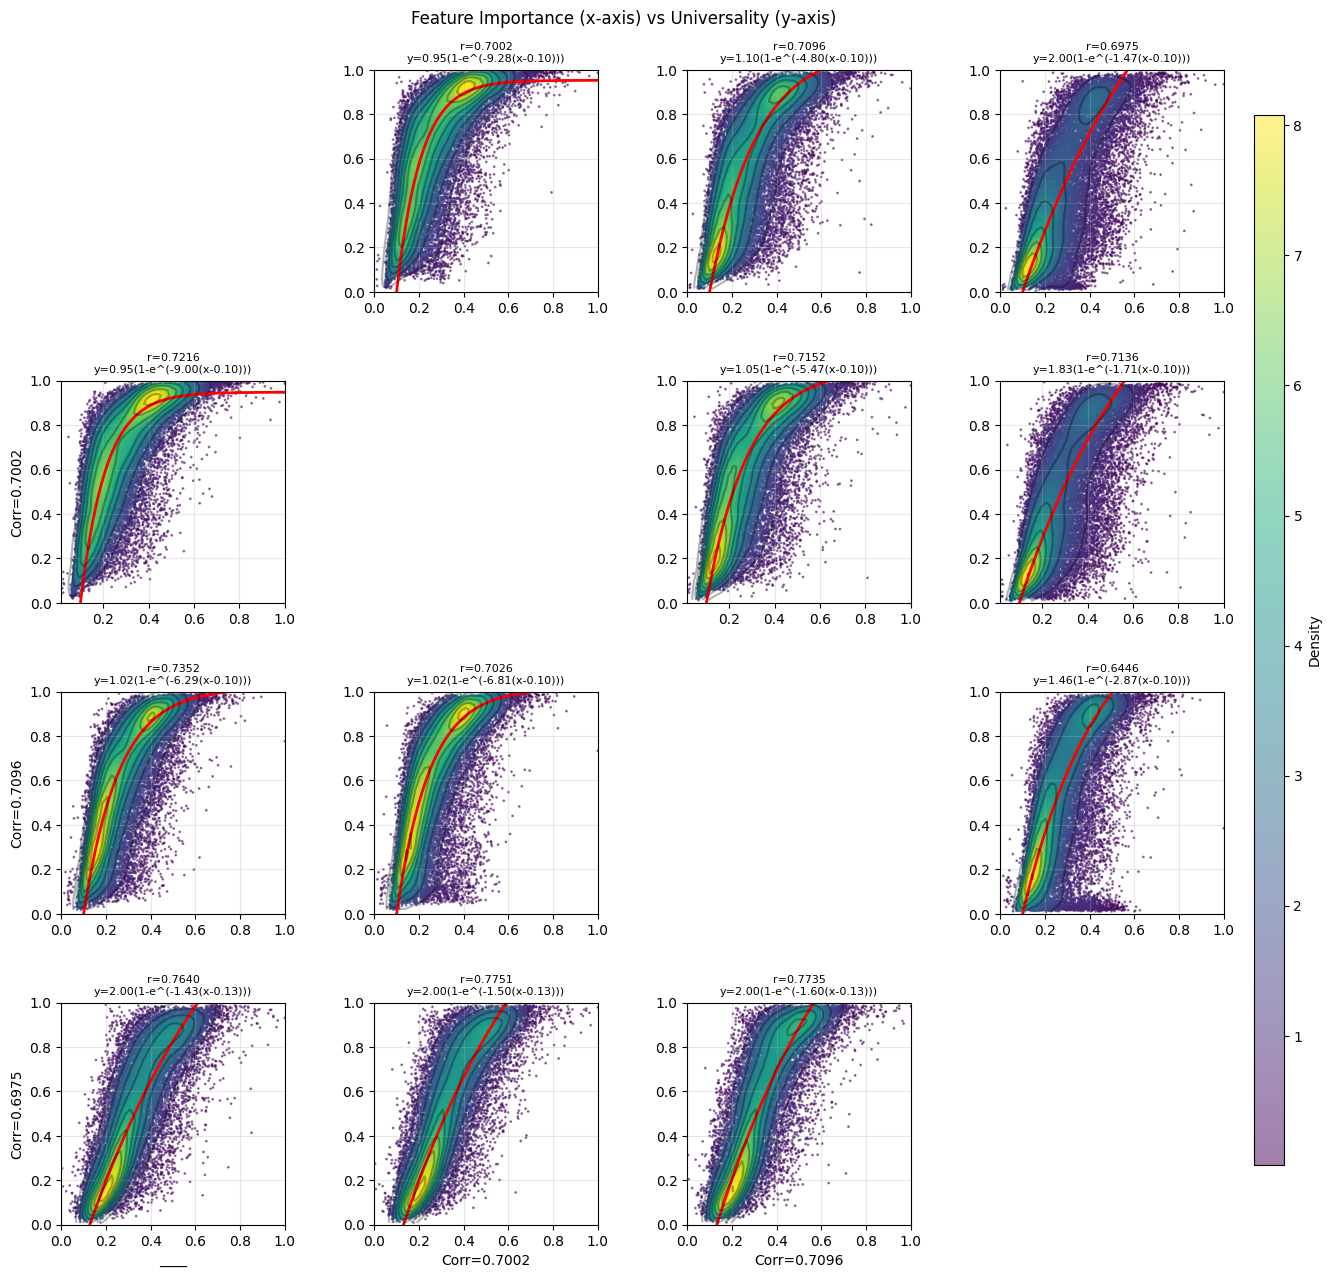

In [10]:
fig, axes = plot_grid_matplotlib_with_fit(masked_scatter_data, masked_corr_coefs, grid_length, masked_subplot_titles)
fig.show()

In [11]:
# TODO: Understand density scatter plot, also what is the scale of the density? Can I make any understanding of the fits as well?
# TODO: are these fits universal? As we change hook place, SAE hyperparameters and model depths do similar patterns hold?

### Learn universality as a function of max activation and sparsity

In [4]:
stats = all_stats[("8-768", "443ngubm"), ("8-512", "fyqbawtf")]
x = stats.max_x
y = stats.density_x.log10()
z = stats.corr_matrix.amax(dim=-1)
x = x / x.max()

x = x.to(dtype=torch.float32)
y = y.to(dtype=torch.float32)
z = z.to(dtype=torch.float32)

In [5]:
# removing -infinity with a large -ve number
y_finite_min = y[y != -float('inf')].min()
y[y == -float('inf')] = 2 * y_finite_min

In [12]:
torch.set_grad_enabled(True)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input layer
        self.fc2 = nn.Linear(64, 64)  # Hidden layer
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Prepare data
# Assuming x, y, and z are already defined as torch tensors
X = torch.stack([x, y], dim=1)  # Shape: (24576, 2)

# Split data into training and validation sets
X_train, X_val, z_train, z_val = train_test_split(X, z, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_val = X_train.float(), X_val.float()
z_train, z_val = z_train.float(), z_val.float()

# Define the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(2000):

    outputs = model(X_train)
    loss = criterion(outputs.view(-1), z_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print losses every 100 epochs
    if epoch % 100 == 0:
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs.view(-1), z_val)
        model.train()

        print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")


Epoch 0, Training Loss: 0.6536, Validation Loss: 0.5463
Epoch 100, Training Loss: 0.0451, Validation Loss: 0.0453
Epoch 200, Training Loss: 0.0375, Validation Loss: 0.0382
Epoch 300, Training Loss: 0.0364, Validation Loss: 0.0371
Epoch 400, Training Loss: 0.0360, Validation Loss: 0.0368
Epoch 500, Training Loss: 0.0357, Validation Loss: 0.0366
Epoch 600, Training Loss: 0.0356, Validation Loss: 0.0364
Epoch 700, Training Loss: 0.0355, Validation Loss: 0.0364
Epoch 800, Training Loss: 0.0354, Validation Loss: 0.0363
Epoch 900, Training Loss: 0.0353, Validation Loss: 0.0362
Epoch 1000, Training Loss: 0.0351, Validation Loss: 0.0361
Epoch 1100, Training Loss: 0.0350, Validation Loss: 0.0360
Epoch 1200, Training Loss: 0.0349, Validation Loss: 0.0359
Epoch 1300, Training Loss: 0.0347, Validation Loss: 0.0358
Epoch 1400, Training Loss: 0.0346, Validation Loss: 0.0357
Epoch 1500, Training Loss: 0.0345, Validation Loss: 0.0356
Epoch 1600, Training Loss: 0.0343, Validation Loss: 0.0354
Epoch 170

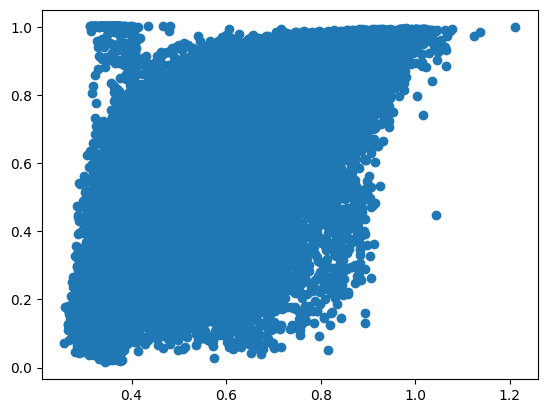

In [24]:
all_outputs = model(X)
plt.scatter(all_outputs.view(-1).detach().cpu().numpy(), z.detach().cpu().numpy())
plt.show()

### Ablations

In [8]:
# type: ignore
import functools
from univ_utils import get_batch, load_data
from tqdm import tqdm

train_data, val_data = load_data("openwebtext")

def ablate_features(model, data, features_max_acts, features_densities, 
                    uninterpretable_mask=None, k=100, batch_size=32, n_batches=10, seed=34, device=device):
    
    assert isinstance(features_max_acts, torch.Tensor)
    assert features_max_acts.ndim == 1, "features_max_acts must be 1D"
    assert isinstance(features_densities, torch.Tensor)
    assert features_densities.ndim == 1, "features_densities must be 1D"
    assert model.acts_to_saes is not None, "model must have SAE spliced in"

    sae_hook_place = list(model.acts_to_saes.keys())[0]
    context_size = model.acts_to_saes[sae_hook_place].cfg.context_size
    d_sae = model.acts_to_saes[sae_hook_place].cfg.d_sae
    hook_name = f"{sae_hook_place}.hook_sae_acts_post"

    top_k_features = features_max_acts.topk(k=k, largest=True).indices
    most_dense_features = features_densities.topk(k=k, largest=True).indices
    
    if uninterpretable_mask is None:
        all_feature_indices = torch.arange(d_sae)
    else:
        all_feature_indices = torch.arange(d_sae)[~uninterpretable_mask]
    num_features = all_feature_indices.shape[0]
    random_features = all_feature_indices[torch.randperm(num_features)[:k]]


    topk_ablated_losses = []
    random_ablated_losses = []
    most_dense_ablated_losses = []

    def ablate_features_hook(acts, hook, features):
        assert acts.ndim == 3, "acts must be 3D"
        acts[:, :, features] = 0
        return acts

    torch.manual_seed(seed)
    for _ in tqdm(range(n_batches)): 
        batch_tokens, _ = get_batch(data, 
                                    block_size=context_size,
                                    batch_size=batch_size,
                                    device=device)


        topk_ablated_loss = model.run_with_hooks(
            batch_tokens,
            return_type="loss",
            fwd_hooks=[(hook_name, functools.partial(ablate_features_hook, features=top_k_features))]
        )

        topk_ablated_losses.append(topk_ablated_loss)

        random_ablated_loss = model.run_with_hooks(
            batch_tokens,
            return_type="loss",
            fwd_hooks=[(hook_name, functools.partial(ablate_features_hook, features=random_features))]
        )

        random_ablated_losses.append(random_ablated_loss)

        most_dense_ablated_loss = model.run_with_hooks(
            batch_tokens,
            return_type="loss",
            fwd_hooks=[(hook_name, functools.partial(ablate_features_hook, features=most_dense_features))]
        )
        most_dense_ablated_losses.append(most_dense_ablated_loss)


    return torch.stack(topk_ablated_losses).mean(), torch.stack(random_ablated_losses).mean(), torch.stack(most_dense_ablated_losses).mean()


In [9]:
# empty memory
torch.cuda.empty_cache()

losses = {}
percents = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for model_name, sae_name in model_sae_pairs:
    model, sae = load_model_and_sae(model_name, sae_name, ckpt_iter=None, device=device)
    assert model.acts_to_saes is not None
    max_acts = torch.tensor(all_max_acts[(model_name, sae_name)])
    densities = torch.tensor(all_densities[(model_name, sae_name)])
    uninterpretable_mask = loaded_masks[(model_name, sae_name)]
    for percent in percents:
        k = int(max_acts.shape[0] * percent)
        topk_ablated_loss, random_ablated_loss, most_dense_ablated_loss = ablate_features(model, train_data, max_acts, densities, uninterpretable_mask=uninterpretable_mask, 
                                                                    k=k, batch_size=4, n_batches=80, seed=34)
        losses[(model_name, sae_name, percent)] = (topk_ablated_loss.cpu(), random_ablated_loss.cpu(), most_dense_ablated_loss.cpu())


/home/zara-ss/Documents/feature_universality/univ_utils.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_file, map_location=device)
/home/za

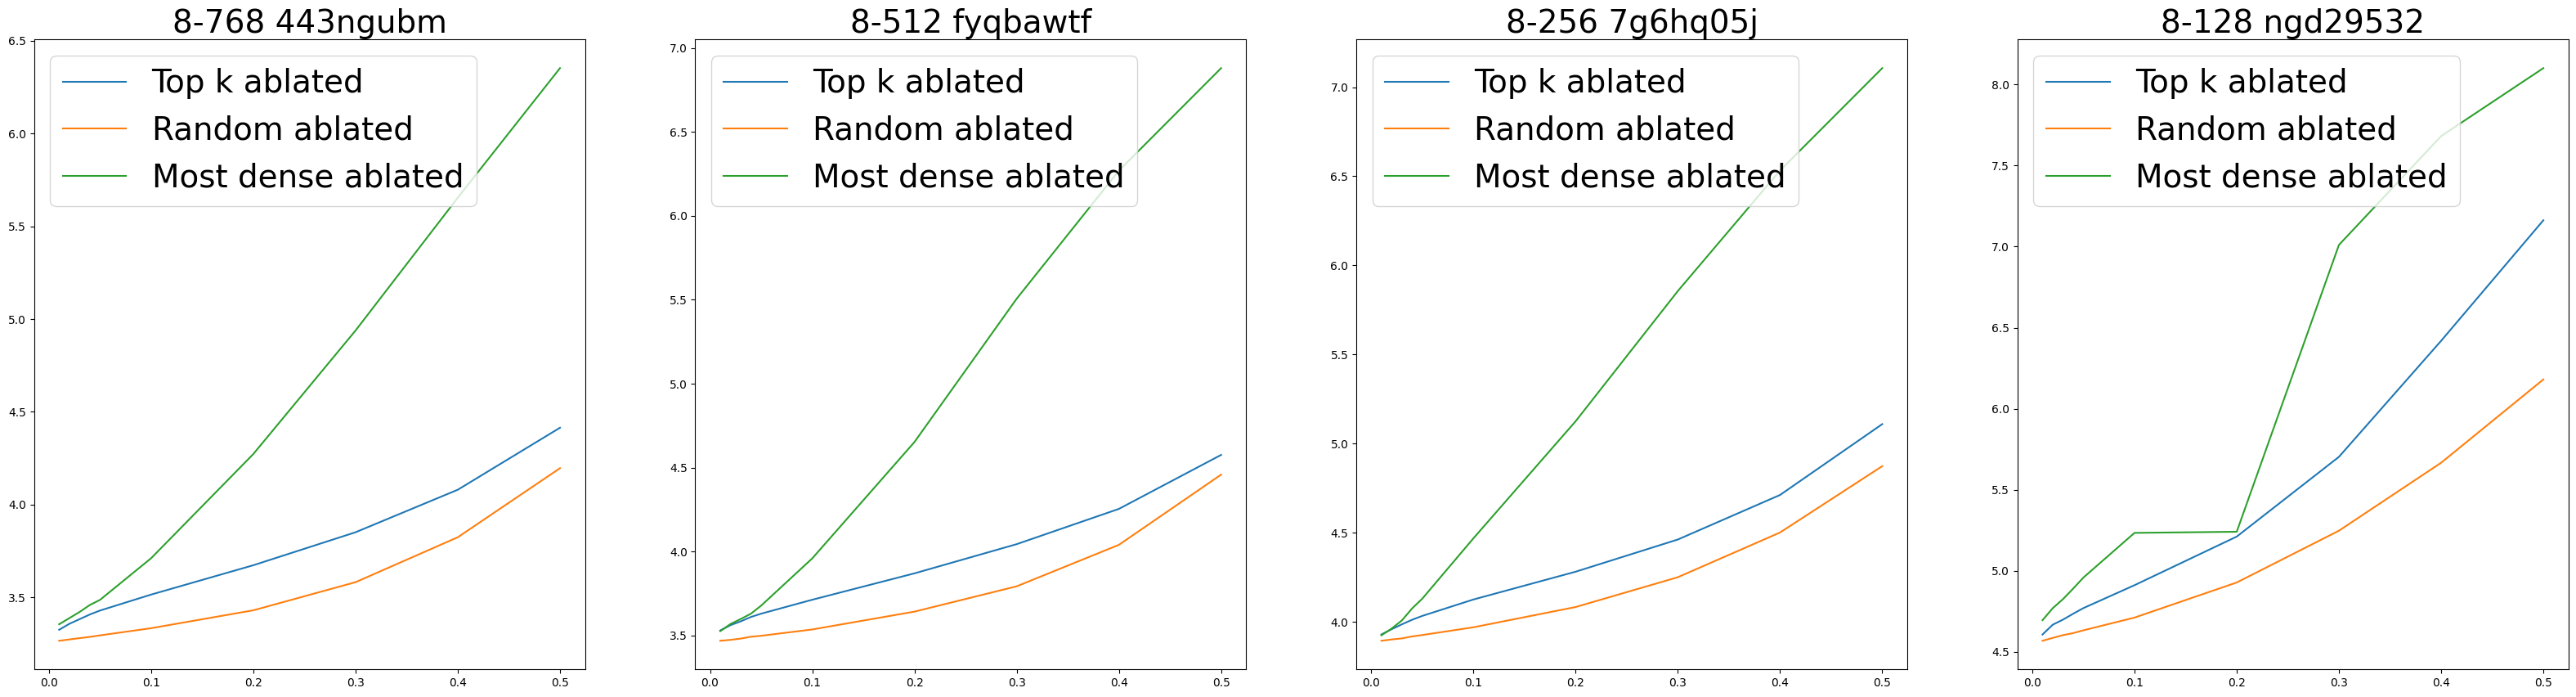

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
for i, (model_name, sae_name) in enumerate(model_sae_pairs):
    topk_ablated_losses = [losses[(model_name, sae_name, percent)][0] for percent in percents]
    random_ablated_losses = [losses[(model_name, sae_name, percent)][1] for percent in percents]
    most_dense_ablated_losses = [losses[(model_name, sae_name, percent)][2] for percent in percents]

    axes[i].plot(percents, topk_ablated_losses, label="Top k ablated")
    axes[i].plot(percents, random_ablated_losses, label="Random ablated")
    axes[i].plot(percents, most_dense_ablated_losses, label="Most dense ablated")
    axes[i].set_title(f"{model_name} {sae_name}", fontsize=28)
    axes[i].legend(fontsize=28)
plt.show()

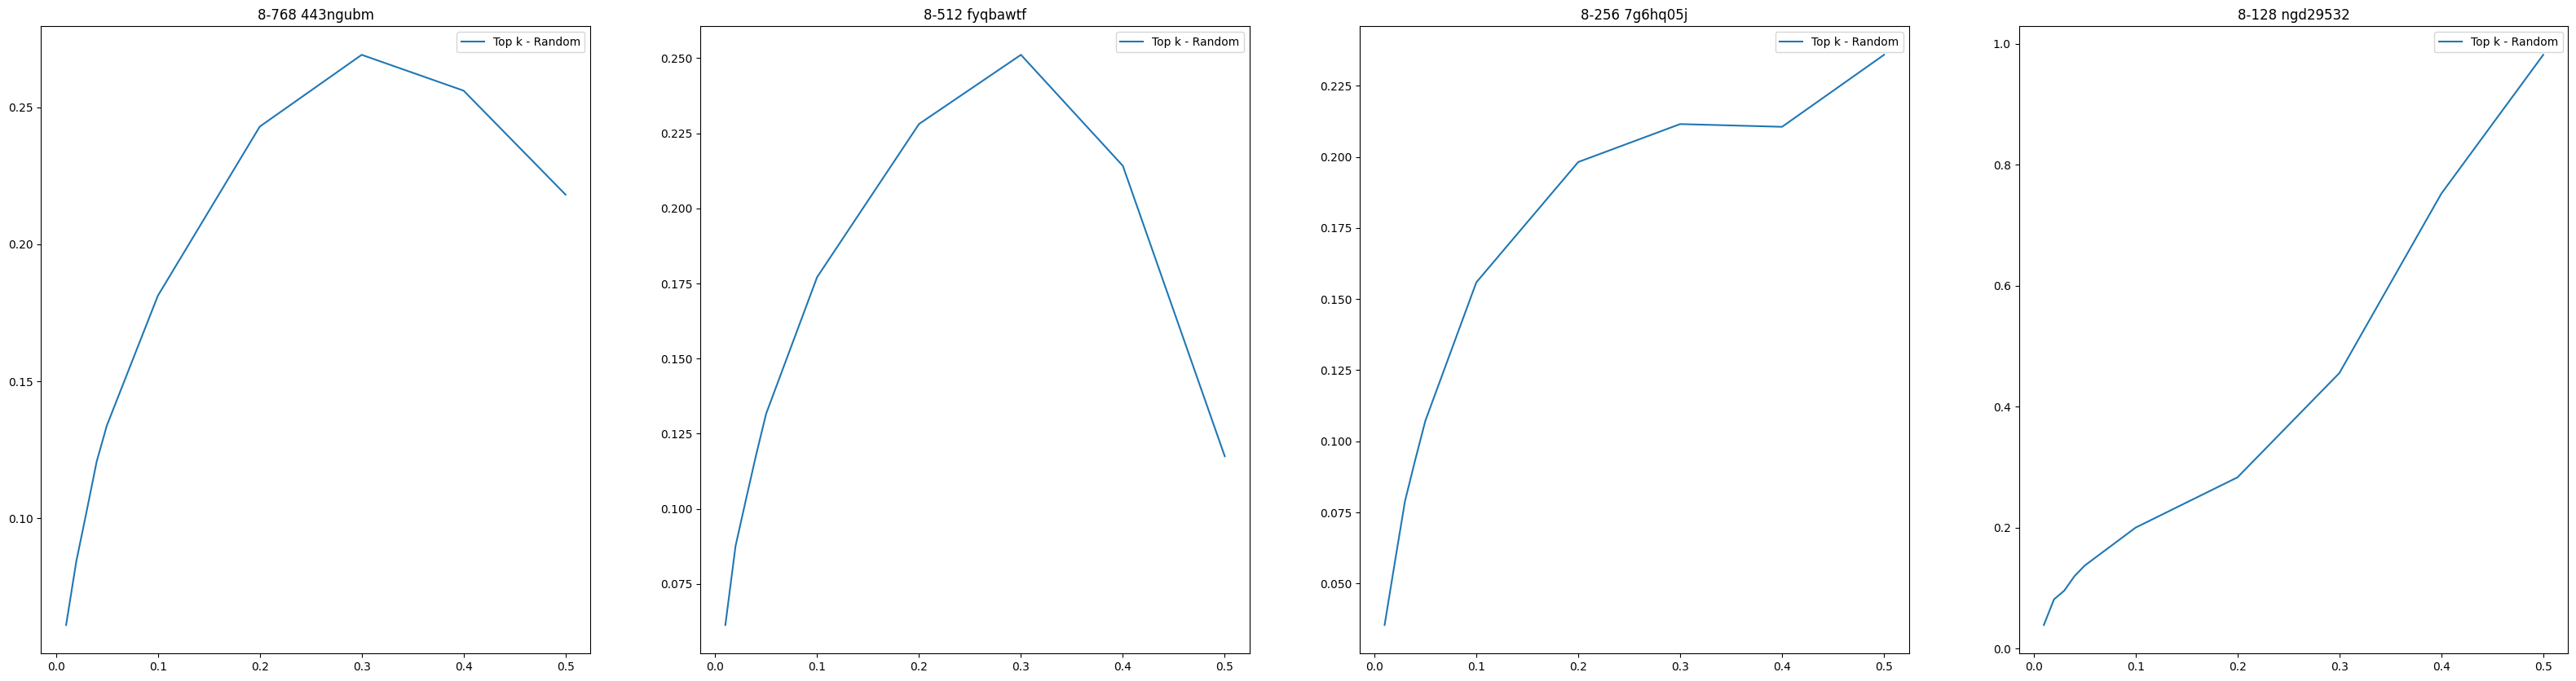

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))
for i, (model_name, sae_name) in enumerate(model_sae_pairs):
    topk_ablated_losses = [losses[(model_name, sae_name, percent)][0] for percent in percents]
    random_ablated_losses = [losses[(model_name, sae_name, percent)][1] for percent in percents]
    most_dense_ablated_losses = [losses[(model_name, sae_name, percent)][2] for percent in percents]
    axes[i].plot(percents, [losses[(model_name, sae_name, percent)][0] - losses[(model_name, sae_name, percent)][1] for percent in percents], label="Top k - Random")
    axes[i].set_title(f"{model_name} {sae_name}")
    axes[i].legend()
plt.show()

### How does the scale of activations and densities scale with models?

Is the scale of model activations a function of compute or model size?

/tmp/ipykernel_19530/3620063039.py:7: RuntimeWarning: divide by zero encountered in log10
  densities = np.log10(all_densities[(model_name, sae_name)][~uninterpretable_mask])


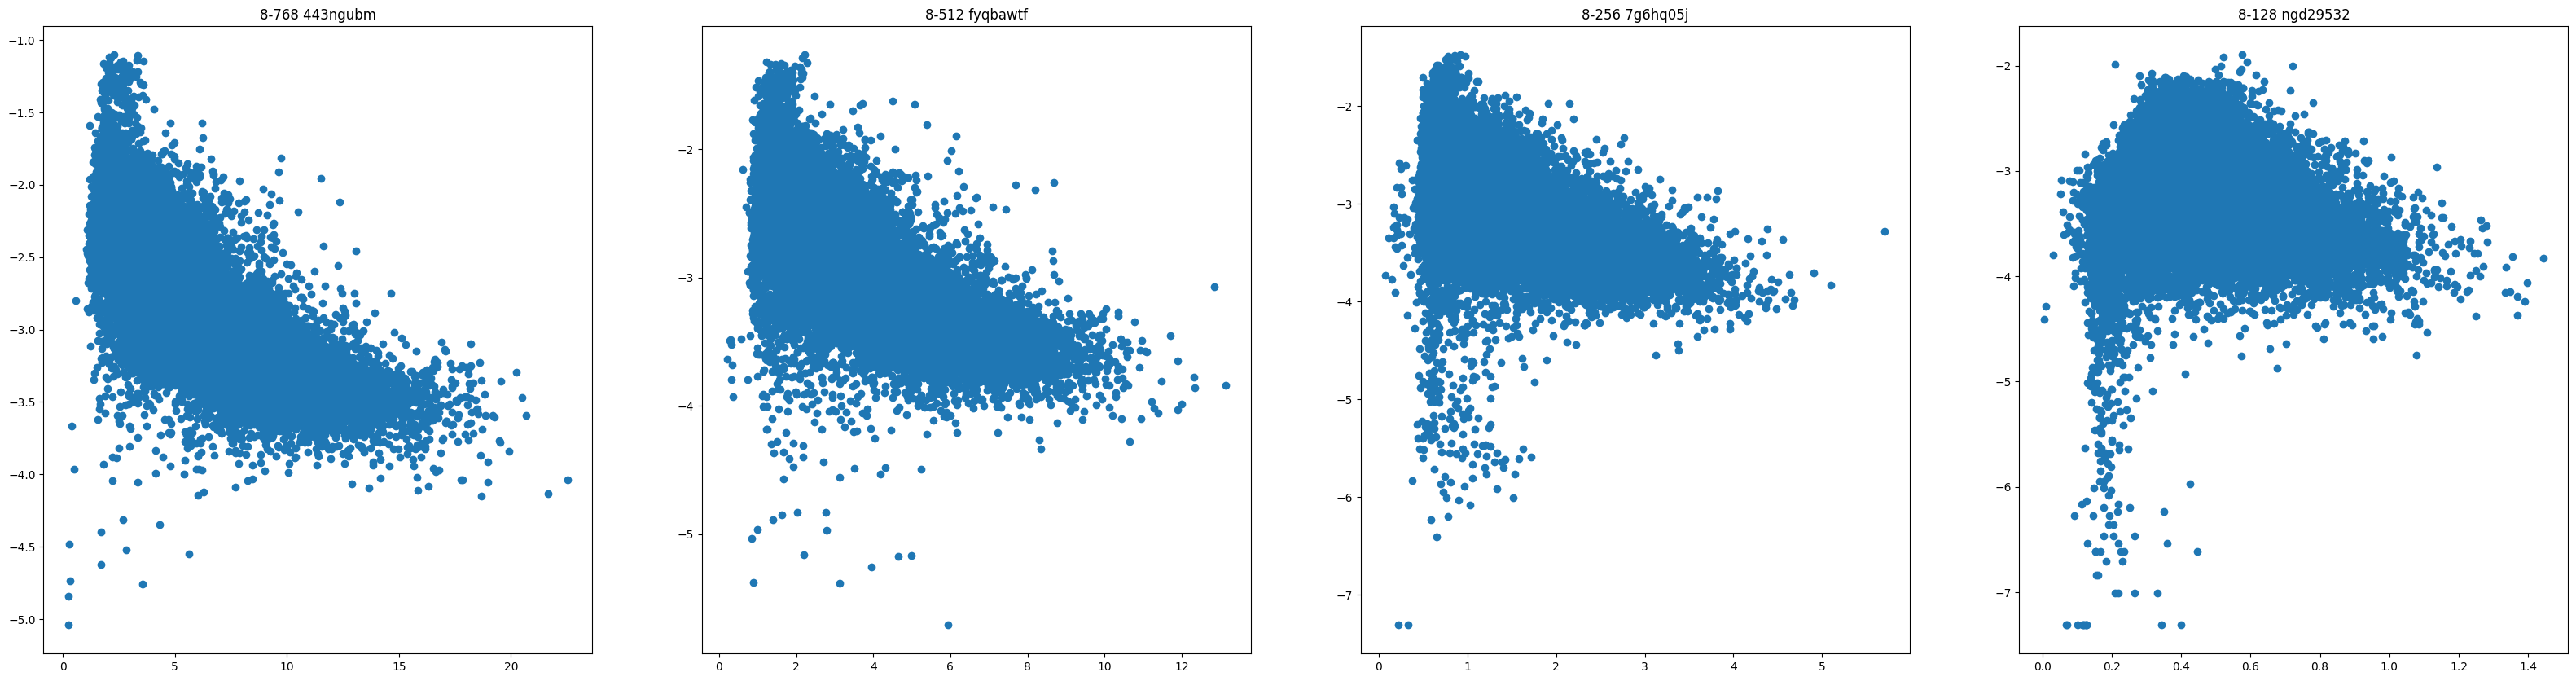

In [63]:
# Are more important features less dense?

fig, axes = plt.subplots(1, 4, figsize=(40, 10))
for i, (model_name, sae_name) in enumerate(model_sae_pairs):
    uninterpretable_mask = loaded_masks[(model_name, sae_name)]
    max_acts = all_max_acts[(model_name, sae_name)][~uninterpretable_mask]
    densities = np.log10(all_densities[(model_name, sae_name)][~uninterpretable_mask])
    axes[i].scatter(max_acts, densities)
    axes[i].set_title(f"{model_name} {sae_name}")
plt.show()

/tmp/ipykernel_19530/2628972167.py:29: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(all_densities[(model_name, sae_name)][~uninterpretable_mask])



Stats for 8-768 443ngubm:
X range: [0.244, 22.520]
Y range: [-5.041, -1.102]
Number of points: 24314

Stats for 8-512 fyqbawtf:
X range: [0.205, 13.153]
Y range: [-5.709, -1.266]
Number of points: 24323

Stats for 8-256 7g6hq05j:
X range: [0.079, 5.704]
Y range: [-7.311, -1.477]
Number of points: 23529

Stats for 8-128 ngd29532:
X range: [0.006, 1.443]
Y range: [-7.311, -1.897]
Number of points: 20036


/tmp/ipykernel_19530/2628972167.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


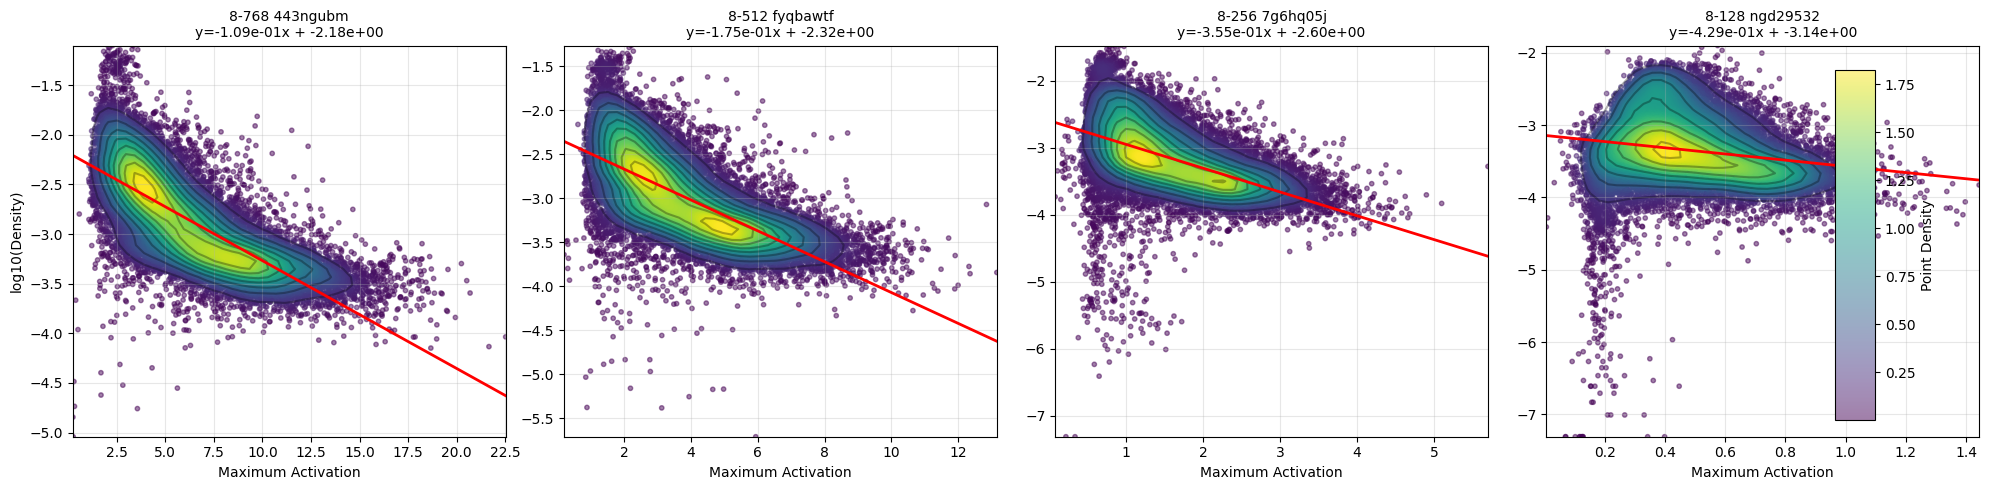

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

def quad_func(x, a, b, c):
    return a * x**2 + b * x + c

def linear_func(x, a, b):
    return a * x + b

def clean_data(x, y):
    # Convert to numpy if needed
    if hasattr(x, 'cpu'):
        x = x.cpu().numpy()
    if hasattr(y, 'cpu'):
        y = y.cpu().numpy()
    # Remove inf and nan values
    mask = np.isfinite(x) & np.isfinite(y)
    return x[mask], y[mask]

def plot_density_relationship(model_sae_pairs, all_max_acts, all_densities, loaded_masks):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, (model_name, sae_name) in enumerate(model_sae_pairs):
        # Get data
        uninterpretable_mask = loaded_masks[(model_name, sae_name)]
        x = all_max_acts[(model_name, sae_name)][~uninterpretable_mask]
        y = np.log10(all_densities[(model_name, sae_name)][~uninterpretable_mask])
        
        # Clean data
        x, y = clean_data(x, y)
        
        # Print data stats before density estimation
        print(f"\nStats for {model_name} {sae_name}:")
        print(f"X range: [{x.min():.3f}, {x.max():.3f}]")
        print(f"Y range: [{y.min():.3f}, {y.max():.3f}]")
        print(f"Number of points: {len(x)}")
        
        # Compute point density for coloring
        xy = np.vstack([x, y])
        try:
            kernel = gaussian_kde(xy)
            density = kernel(xy)
        except Exception as e:
            print(f"Density estimation failed for {model_name} {sae_name}: {e}")
            continue
            
        # Sort points by density
        idx = density.argsort()
        x_sorted = x[idx]
        y_sorted = y[idx]
        density_sorted = density[idx]
        
        # Fit linear function
        try:
            popt, _ = curve_fit(linear_func, x, y)
            x_fit = np.linspace(x.min(), x.max(), 1000)
            y_fit = linear_func(x_fit, *popt)
            fit_success = True
        except Exception as e:
            print(f"Curve fitting failed for {model_name} {sae_name}: {e}")
            fit_success = False
            
        # Create scatter plot with density coloring
        scatter = axes[i].scatter(x_sorted, y_sorted, c=density_sorted, 
                                s=10, alpha=0.5, cmap='viridis')
        
        # Add contours
        try:
            xgrid = np.linspace(x.min(), x.max(), 50)
            ygrid = np.linspace(y.min(), y.max(), 50)
            Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
            positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
            Z = kernel(positions).reshape(Xgrid.shape)
            axes[i].contour(Xgrid, Ygrid, Z, levels=8, colors='k', alpha=0.3)
        except Exception as e:
            print(f"Contour plotting failed for {model_name} {sae_name}: {e}")
        
        # Plot fitted curve if successful
        if fit_success:
            axes[i].plot(x_fit, y_fit, 'r-', linewidth=2)
            fit_eq = f"\ny={popt[0]:.2e}x + {popt[1]:.2e}"
        else:
            fit_eq = "\nFit failed"
            
        # Customize plot
        axes[i].set_title(f"{model_name} {sae_name}{fit_eq}", fontsize=10)
        axes[i].set_xlabel('Maximum Activation')
        axes[i].set_ylabel('log10(Density)' if i == 0 else '')
        axes[i].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(scatter, cax=cbar_ax, label='Point Density')
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

# Call the function
fig, axes = plot_density_relationship(model_sae_pairs, all_max_acts, all_densities, loaded_masks)